## Solving satisfiability problems using Grover’s Algorithm
##### Quantum Computing - Final project 

Trabalho realizado por:
- Nelson Almeida (a95652)
- Nuno Costa (a97610)

## Criação da fórmula booleana 3-SAT
Consideremos a seguinte fórmula $f$,

$$f(v1,v2,v3) = (\neg v1 \lor \neg v2 \lor \neg v3) \land (v1 \lor \neg v2 \lor v3) \land (v1 \lor v2 \lor \neg v3) \land (v1 \lor \neg v2 \lor \neg v3) \land (\neg v1 \lor v2 \lor v3)$$

In [59]:
drawTable()         

╒══════╤══════╤══════╤═════╤═══════════════╕
│   v1 │   v2 │   v3 │   f │ Comentário    │
╞══════╪══════╪══════╪═════╪═══════════════╡
│    0 │    0 │    0 │   1 │ Solução       │
├──────┼──────┼──────┼─────┼───────────────┤
│    0 │    0 │    1 │   0 │ Não é solução │
├──────┼──────┼──────┼─────┼───────────────┤
│    0 │    1 │    0 │   0 │ Não é solução │
├──────┼──────┼──────┼─────┼───────────────┤
│    0 │    1 │    1 │   0 │ Não é solução │
├──────┼──────┼──────┼─────┼───────────────┤
│    1 │    0 │    0 │   0 │ Não é solução │
├──────┼──────┼──────┼─────┼───────────────┤
│    1 │    0 │    1 │   1 │ Solução       │
├──────┼──────┼──────┼─────┼───────────────┤
│    1 │    1 │    0 │   1 │ Solução       │
├──────┼──────┼──────┼─────┼───────────────┤
│    1 │    1 │    1 │   0 │ Não é solução │
╘══════╧══════╧══════╧═════╧═══════════════╛



Pela observação da tabela lógica obtida, podemos concluir que, estamos perante uma fórmula booleana 3-SAT com solução, tal como pretendíamos.

## Implementação do algoritmo de Grover

In [9]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, AncillaRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_distribution
from qiskit.circuit.library import ZGate, MCXGate
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

In [10]:
def execute_circuit(qc, shots=1024, decimal=False, reversed=False):
    
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = execute(qc, device, shots=shots).result().get_counts()
    
    if decimal:
        if reversed:
            counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
        else:
            counts = dict((int(a,2),b) for (a,b) in counts.items())
    else:
        if reversed:
            counts = dict((a[::-1],b) for (a,b) in counts.items())
        else:
            counts = dict((a,b) for (a,b) in counts.items())

    return counts

#### O algoritmo de Grover é composto por três etapas: inicialização, oráculo e difusor. 

#### 1. Inicialização:
Começamos pela função "initializeCircuit" que é utilizada para criar e inicializar o circuito quântico.<br>
O circuito criado é composto por $numQubits$ registos quanticos, 1 registo quântico auxiliar e $numQubits$ registos clássicos para a medição de resultados.<br>
Começamos por inicializar todos os qubits de $qr$ no estado de sobreposição uniforme, utilizando a Gate de Hadamard, posteriormente inicializamos a ancilla no estado 1 de sobreposição ($|->$).

In [11]:
def initializeCircuit(numQubits):
    qr = QuantumRegister(numQubits,name="v")
    ancilla = AncillaRegister(1,name="ancilla")
    cr = ClassicalRegister(numQubits)
    qc = QuantumCircuit(qr,ancilla,cr)
    
    #uniform superposition qr
    qc.h(qr)
    #|-> state ancilla
    qc.x(ancilla)
    qc.h(ancilla)
    qc.barrier(label="Initialization Barrier")
    
    return qc,qr,ancilla,cr

#### 2. Oráculo:
A função de Oráculo toma partido da Gate Multiple Controlled-X que recebe um estado de controlo, no nosso caso seria a solução pretendida, e aplica ao circuito com base neste argumento.

In [12]:
def oracle(qr, ancilla, solution=None):
    
    qc = QuantumCircuit(qr,ancilla)
    cx_gate = MCXGate(len(qr),ctrl_state=solution)
    qc = qc.compose(cx_gate)
    
    qc.barrier()
    return qc

#### 3. Operador de difusão:
Por fim, definimos um operador de difusão, este operador vai potenciar os resultados marcados com o oráculo.

In [13]:
def diffusion_operator(qr, ancilla, n_qubits):

    qc = QuantumCircuit(qr,ancilla)

    qc.h(qr)
    qc.x(qr[-1])
    cz = ZGate().control(n_qubits-1,ctrl_state="0"*(n_qubits-1))
    qc = qc.compose(cz)
    qc.x(qr[-1])
    qc.h(qr)
    
    return qc 

Função para executar o algoritmo de Grover para resolver o problema de satisfatibilidade:

In [18]:
def executeGroover3SAT(iterations, solutions=[]):
    if solutions!=[]:
        numQubits = len(solutions[0])
        qc,qr,ancilla,cr=initializeCircuit(numQubits)
        
        for j in range(iterations):
            for solution in solutions:
                qc = qc.compose(oracle(qr,ancilla, solution))
            qc = qc.compose(diffusion_operator(qr,ancilla, len(solutions)))
        qc.measure(qr,cr)
    
        return qc

## Execução do algoritmo de Grover

Com a ilustração abaixo podemos constatar como ocorre a execução do algoritmo, vemos claramente a fase de inicialização, a fase da aplicação do oráculo e do operador de difusão.

É também evidente que apenas ocorreu uma iteração deste algoritmo. O número de iterações é nos dados pela seguinte equação


$$t=\pi/4 * \sqrt{N/M}$$


Onde, no nosso caso, N=$2^3$ e M=$3$.
O que se traduz numa complexidade de $\mathcal{O}(\sqrt{N/M})$, visto este ser o número de iterações.

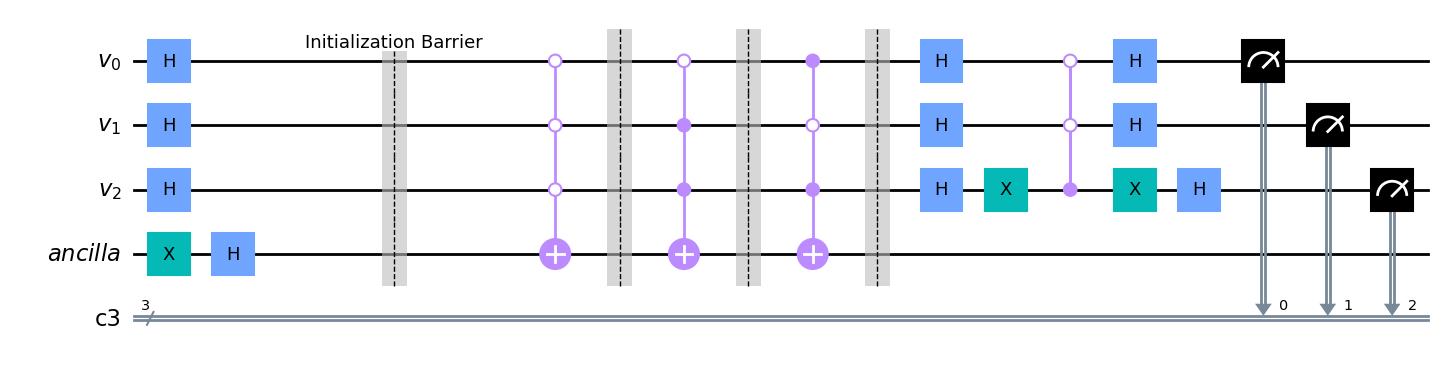

In [19]:
solutions = ["000","110","101"]
N = 2**len(solutions[0])
iterations = int(np.pi/4*np.sqrt(N/len(solutions)))

qc = executeGroover3SAT(iterations, solutions)
qc.draw(output="mpl")

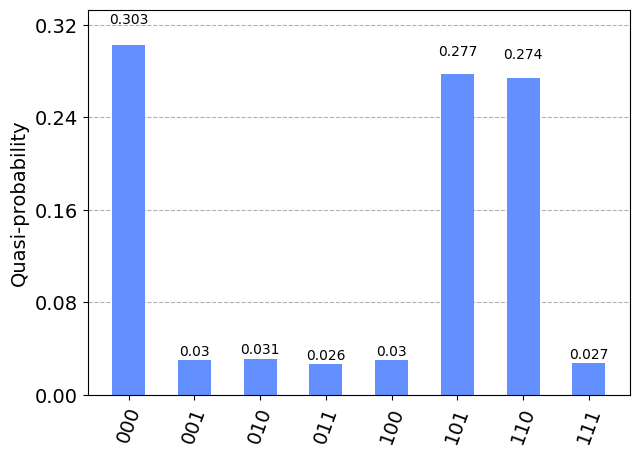

In [20]:
counts = execute_circuit(qc)
plot_distribution(counts)

### Para um número de iterações diferente do "ideal"

In [23]:
solutions = ["000","110","101"]
iterations = 5

qc = executeGroover3SAT(iterations,solutions)
#qc.draw(output="mpl")

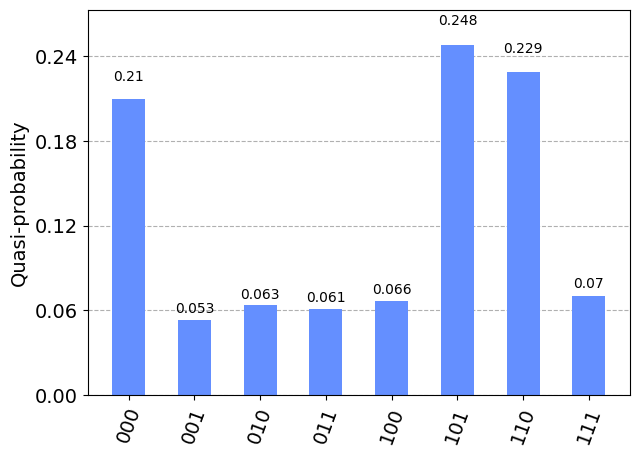

In [26]:
counts = execute_circuit(qc)
plot_distribution(counts)

Para o número de iterações igual a 5, constatamos que as probabilidades de obtermos resultados favoráveis são inferiores face às retornadas pelo número de iterações ideal.

In [30]:
solutions = ["000","110","101"]
iterations = 10

qc = executeGroover3SAT(iterations,solutions)
#qc.draw(output="mpl")

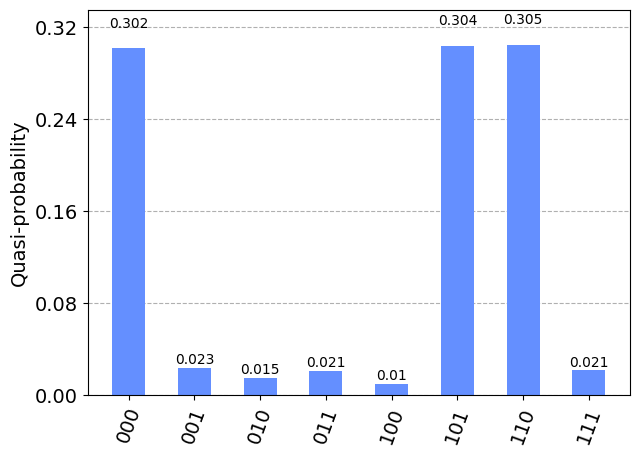

In [31]:
counts = execute_circuit(qc)
plot_distribution(counts)

Para o número de iterações igual a 5, constatamos que as probabilidades de obtermos resultados favoráveis são inferiores face às retornadas pelo número de iterações ideal.

## Conclusão
Teoricamente teríamos igual probabilidade de obter os resultados |000>, |101>, |110>, isto é, aproximadamente 0.33. Constatamos no entanto que no nosso melhor caso, para 10 iterações, temos um resultado com probabilidades de 0.302, 0.304 e 0.305 respetivamente, o que é próximo do ideal.

Concluimos portanto que para 10 iterações apesar de ser um número diferente do ideal fica mais perto dos resultados esperados.

# Funções auxiliares

In [60]:
def expression(v1,v2,v3):
    return int((not v1 or not v2 or not v3) and (v1 or not v2 or  v3) and (v1 or v2 or not v3) and (v1 or not v2 or not v3) and (not v1 or v2 or v3))

def drawTable():
    table ={"v1":[], "v2":[], "v3":[], "f":[], "Comentário":[]}
    for v1 in range(2):
        for v2 in range(2):
            for v3 in range(2):
                table["v1"].append(v1)
                table["v2"].append(v2)
                table["v3"].append(v3)
                result = expression(v1,v2,v3)
                table["f"].append(result)
                if result==1:
                    table["Comentário"].append("Solução")
                else:
                    table["Comentário"].append("Não é solução")        
    print(tabulate(table, tablefmt="fancy_grid", headers="keys")) 